# <a id='toc1_'></a>[PARKINSON DETECTION BY SNIFFER DOGS](#toc0_)



**Table of contents**<a id='toc0_'></a>    
- [PARKINSON DETECTION BY SNIFFER DOGS](#toc1_)    
- [LIBRARIES](#toc2_)    
- [REGISTER DATA SET](#toc3_)    
- [CLASS NAMES](#toc4_)    
- [SETUP THE MODEL FOR INFERENCE](#toc5_)    
- [INFERENCE ON IMAGES](#toc6_)    
- [INFERENCE ON VIDEO](#toc7_)    
- [START AND STOP SNIFFING](#toc8_)    
- [SAVE SNIFFING SNIPPETS](#toc9_)    
- [CSV](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[LIBRARIES](#toc0_)

In [1446]:
import time
startTotalTime = time.time()

In [1447]:
# USE AAI3

!python --version
print("")

# Torch
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
print(f"Torch version: {TORCH_VERSION}")


# Cuda
CUDA_VERSION = torch.__version__.split("+")[-1]
print(f"cuda version: {CUDA_VERSION}")
print("Torch cuda is available :", torch.cuda.is_available())

print("")
!nvcc --version

# Detectron2
import detectron2
print("")
print("detectron2:", detectron2.__version__)

from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader, DatasetMapper
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor

from detectron2.utils.visualizer import Visualizer, ColorMode

# Cv2 
# conda install -c conda-forge opencv
import cv2
print("cv2:", cv2.__version__)

# Scipy
# pip install scipy
import scipy
print("Scipy version:", scipy.__version__)

# Sklearn
# pip install scikit-learn
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Import CountVectorizer to create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

# To Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

#import to use an TF-IDF Vectorizer Object, to Remove all english stop words such as 'the', 'a'
from sklearn.feature_extraction.text import TfidfVectorizer
from ast import literal_eval

# and other libraries
import os
import glob

import pandas as pd
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import random
import json
import pickle
import requests
import time 
import shutil
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import logging # I use this to have more information about what's going on
logging.basicConfig()
log = logging.getLogger()
log.setLevel('INFO')


import cv2
import os
import math
import moviepy as mp

Python 3.13.2

Torch version: 2.6
cuda version: cu126
Torch cuda is available : True

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0

detectron2: 0.6
cv2: 4.11.0
Scipy version: 1.15.2


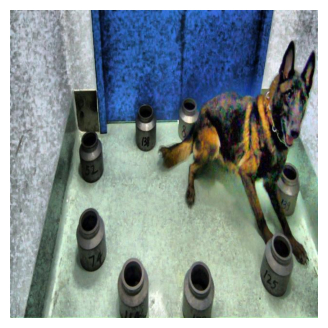

[06/07 00:46:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /root/.torch/iopath_cache/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...
INFO:fvcore.common.checkpoint:Reading a file from 'Detectron2 Model Zoo'


tensor([39, 39], device='cuda:0')
Boxes(tensor([[554.2310, 321.2246, 602.3782, 431.3213],
        [143.8848, 252.6888, 195.3421, 358.7485]], device='cuda:0'))


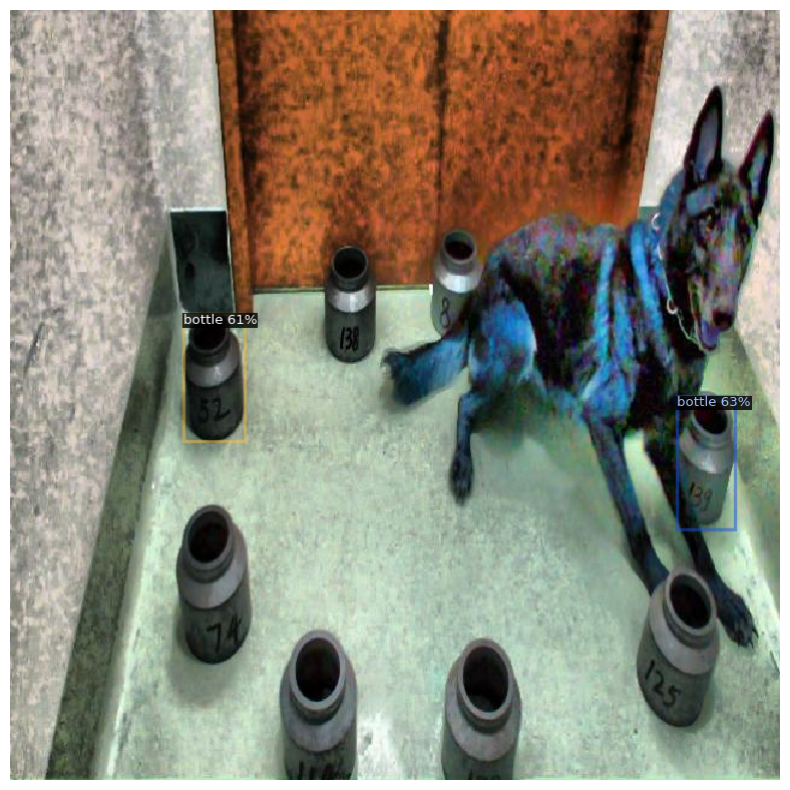

Time taken to run the inference for the COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml model: 0.0 min


In [1448]:
model = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

# other models
model1 = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
model2 = "COCO-Detection/retinanet_R_101_FPN_3x.yaml" 
model3 = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"

test_image = "pks.v1i.coco/pks.v1i.coco/test/DSCN2641-corp_mp4-0008_jpg.rf.f42554044770a8a049bcf8c33e75adb9.jpg"

im_infer = cv2.imread(test_image)

# #Plot image---
plt.figure(figsize=(4,4))
image = cv2.cvtColor(im_infer, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

t1 = time.time()
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file(model)) 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 #Lower value (e.g., 0.5) = More permissive, includes less confident predictions
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model) 

predictor = DefaultPredictor(cfg)
outputs = predictor(im_infer)

print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

v = Visualizer(im_infer[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(10,10))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

t2 = time.time()
time_taken = t2-t1
tt = round(time_taken/60, 0)
print(f"Time taken to run the inference for the {model} model: {tt} min")



# PARAMETER
update the video numbers in the list below and press run all 

In [1449]:
list_to_do = [2643, 2644, 2645] # for 3191 use original video

snipfolder = "LongerSnippetIsabelle/"

threshold = 0.7 #was 0.8. make it higher when paws and tails are detected, make it lower when tanks are not detected

threshold_bb = 0.15 # 
# stops and start the sniffing moment
# lower this value if multiple pots are sniffed in one snippet. 
# if not, make the value higher 

iou_threshold= 0.01 # merging bounding boxes that are touching each other 
# when tanks are next to each other this value must be very high eg 0.9 
# if it is lower the tanks will be merged to 1 bounding box
# for other videos where tanks are not placed in a row next to each other this was 0.05

# isabelle_batch_2_3 = [
#  2632, 2634, 2635, 2636, 2637, 2638, 
# 2639, 2640, 2641, 2642, 2643, 2644, 2645,
# 2621, 2627, 2628, 2629] 
## labelled: 2630, 2631


# yaya_batch_4 = [2678, 2679, 2649, 2650, 2651, 2652, 2653, 2654, 
#    2665, 2666, 2667, 2671, 2672, 2673, 
# 2674, 2675,2676,2677] 
## 


# tomas_batch_1_5 = [2680, 2681, 2682, 2683, 2685, 2686, 2690, 2692, 2693, 2695, 2696, 2698, 2702, 2703, 2704, 3191, 3193, 3194, 3195, 3196, 3197, 3198, 3199]  
# for 3191 use orinal video





# <a id='toc3_'></a>[TO DO REGISTER DATA SET](#toc0_)

In [1450]:
# cvat
orig_json_path = "cvat_robo_anno/pks_n_t_v2/annotations/instances_default.json"
images_folder = "cvat_robo_anno/pks_n_t_v2/annotations/"
dataset_name    = "nose_tank_cvat"


clean_json_path = "cvat_robo_anno/pks_n_t_v2/annotations/instances_cleaned.json"

with open(orig_json_path, "r") as f:
    coco = json.load(f)

print(f"Original JSON has {len(coco['images'])} images and {len(coco['annotations'])} annotations.")

Original JSON has 156 images and 1058 annotations.


In [1451]:
valid_image_ids = set()
new_images_list = []

for img in coco["images"]:

    img_path = os.path.join(images_folder, img["file_name"])
    if os.path.exists(img_path):
        valid_image_ids.add(img["id"])
        new_images_list.append(img)
    else:
        pass

print(f"Found {len(valid_image_ids)} existing images. {len(coco['images']) - len(valid_image_ids)} were missing and dropped.")


Found 156 existing images. 0 were missing and dropped.


In [1452]:
new_annotations_list = [
    ann for ann in coco["annotations"]
    if ann["image_id"] in valid_image_ids
]
print(f"Kept {len(new_annotations_list)} annotations out of {len(coco['annotations'])} original.")

Kept 1058 annotations out of 1058 original.


In [1453]:
coco_cleaned = {
    "info":       coco.get("info", {}),
    "licenses":   coco.get("licenses", []),
    "images":     new_images_list,
    "annotations":new_annotations_list,
    "categories": coco["categories"],
}

os.makedirs(os.path.dirname(clean_json_path), exist_ok=True)
with open(clean_json_path, "w") as f:
    json.dump(coco_cleaned, f)
print(f"Cleaned JSON written to: {clean_json_path}")

Cleaned JSON written to: cvat_robo_anno/pks_n_t_v2/annotations/instances_cleaned.json


# TO DO REGISTER DATASET

In [1454]:
dataset_name    = "nose_tank_cleaned"

with open(clean_json_path, "r") as f:
    coco_dict = json.load(f)

thing_classes = [c["name"] for c in coco_dict["categories"]]
print("Extracted thing_classes:", thing_classes)

register_coco_instances(
    dataset_name,
    {},
    clean_json_path,
    images_folder
)

MetadataCatalog.get(dataset_name).set(thing_classes=thing_classes)

metadata = MetadataCatalog.get(dataset_name)
print("Verified thing_classes in metadata:", metadata.thing_classes)

Extracted thing_classes: ['nose', 'tank']
Verified thing_classes in metadata: ['nose', 'tank']


In [1455]:
import random, cv2, matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get(dataset_name)
# sample = random.choice(dataset_dicts)
# img = cv2.imread(sample["file_name"])
# v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
# out = v.draw_dataset_dict(sample)

# plt.figure(figsize=(10, 6))
# plt.imshow(out.get_image())
# plt.axis("off")


[06/07 00:46:19 d2.data.datasets.coco]: Loaded 156 images in COCO format from cvat_robo_anno/pks_n_t_v2/annotations/instances_cleaned.json


In [1456]:
import os
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()

cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
)

cfg.DATASETS.TRAIN = (dataset_name,)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
)

#cfg.OUTPUT_DIR = "/content/drive/MyDrive/pks_v2/pk_n_t/output_cleaned"

cfg.OUTPUT_DIR = "cvat_robo_anno/pks_n_t_v2/output_cleaned"


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# parameters
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.STEPS = []

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

print("Config built. Check output directory:", cfg.OUTPUT_DIR)

Config built. Check output directory: cvat_robo_anno/pks_n_t_v2/output_cleaned


# SETUP MODEL

UNCOMMENT IF RETRAIN IS NEEDED 

In [1457]:
# from detectron2.engine import DefaultTrainer

# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

In [1458]:
import os
import shutil


#detectron_output_dir = "/content/drive/MyDrive/pks_v2/pk_n_t/output_cleaned"

detectron_output_dir = "cvat_robo_anno/pks_n_t_v2/output_cleaned"

#target_dir = "/content/drive/MyDrive/pks_v2"

target_dir = "cvat_robo_anno/pks_n_t_v2/pks_v2"

os.makedirs(target_dir, exist_ok=True)

final_ckpt = os.path.join(detectron_output_dir, "model_final.pth")

if not os.path.exists(final_ckpt):

    all_ckpts = [
        os.path.join(detectron_output_dir, fname)
        for fname in os.listdir(detectron_output_dir)
        if fname.startswith("model_") and fname.endswith(".pth")
    ]
    if len(all_ckpts) == 0:
        raise FileNotFoundError(f"No model_*.pth found in {detectron_output_dir}")

    all_ckpts.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    final_ckpt = all_ckpts[0]

print("Using checkpoint:", final_ckpt)


dest_ckpt = os.path.join(target_dir, os.path.basename(final_ckpt))
shutil.copy(final_ckpt, dest_ckpt)
print(f"Copied {final_ckpt} → {dest_ckpt}")


src_cfg = os.path.join(detectron_output_dir, "config.yaml")
if os.path.exists(src_cfg):
    dest_cfg = os.path.join(target_dir, "det_config.yaml")
    shutil.copy(src_cfg, dest_cfg)
    print(f"Copied {src_cfg} → {dest_cfg}")
else:
    print("Warning: no config.yaml found in detectron_output_dir")

Using checkpoint: cvat_robo_anno/pks_n_t_v2/output_cleaned/model_final.pth
Copied cvat_robo_anno/pks_n_t_v2/output_cleaned/model_final.pth → cvat_robo_anno/pks_n_t_v2/pks_v2/model_final.pth


In [1459]:
#!python cocosplit.py --having-annotations --multi-class -s 0.8 cvat_robo_anno/pks_n_t_v2/annotations/instances_default.json train.json val.json

In [1460]:
# json_path = "cvat_robo_anno/pks_n_t_v2/annotations/instances_default.json"
# images_folder = "cvat_robo_anno/pk_n_t_cvat/images/"
# dataset_name    = "nose_tank_cvat"

# source_dir = "cvat_robo_anno/pks_n_t_v2/annotations/"

# #Register datasets
# register_coco_instances('train', {}, os.path.join(source_dir, 'train.json'), source_dir)
# register_coco_instances('val', {}, os.path.join(source_dir, 'val.json'), source_dir)

# #Get the internal representation
# train_dicts = DatasetCatalog.get("train")
# test_dicts = DatasetCatalog.get("val")

# #Get the metadata
# train_metadata = MetadataCatalog.get("train")
# test_metadata = MetadataCatalog.get("val")

# print(f"Registered objects")

# print("Number of images in train set: ")
# print(len(DatasetCatalog.get("train")))
# print("Number of images in val set: ")
# print(len(DatasetCatalog.get("val")))

# <a id='toc4_'></a>[TO DO CLASS NAMES](#toc0_)

In [1461]:
print(metadata)
print("Config built. Check output directory:", cfg.OUTPUT_DIR)
print("Class names:", metadata.get("thing_classes"))
nr_classes = len(metadata.get("thing_classes"))
nr_classes


Metadata(name='nose_tank_cleaned', json_file='cvat_robo_anno/pks_n_t_v2/annotations/instances_cleaned.json', image_root='cvat_robo_anno/pks_n_t_v2/annotations/', evaluator_type='coco', thing_classes=['nose', 'tank'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1})
Config built. Check output directory: cvat_robo_anno/pks_n_t_v2/output_cleaned
Class names: ['nose', 'tank']


2

## SETUP MODEL 

In [1462]:
# used_model = model
# # model = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

# class MyTrainer(DefaultTrainer):
#     @classmethod
#     def build_evaluator(cls, cfg, dataset_name, output_folder=None):
#         if output_folder is None:
#             output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
#         return COCOEvaluator(
#             dataset_name,
#             tasks=("bbox",),
#             distributed=False,
#             output_dir=output_folder,
#         )

# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file(used_model)) 
# cfg.DATASETS.TRAIN = ("train",)
# cfg.DATASETS.TEST = ("val",)

# cfg.DATALOADER.NUM_WORKERS = 2

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(used_model)  

# cfg.SOLVER.IMS_PER_BATCH = 2

# cfg.SOLVER.BASE_LR = 0.00025  # Learning rate

# cfg.SOLVER.MAX_ITER = 5000    # Number of iterations

# cfg.SOLVER.STEPS = [2000, 3500] # Learning rate decay points

# cfg.SOLVER.GAMMA = 0.1        # Learning rate decay factor # Learning rate decay factor (10x reduction)

# cfg.SOLVER.WARMUP_METHOD = "linear"

# cfg.SOLVER.WARMUP_ITERS = 100

# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

# cfg.TEST.EVAL_PERIOD = 2500  # Run evaluation every 2500 iterations

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [1463]:
# start_training = time.time()

# trainer = MyTrainer(cfg)
# trainer.resume_or_load(resume=False)

# trainer.train()

# end_training = time.time()

# <a id='toc5_'></a>[SETUP THE MODEL FOR INFERENCE](#toc0_)

In [1464]:
def setup_detectron2(nr_classes=nr_classes, threshold=threshold, cfg = cfg):

    # model =  "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
    # cfg = get_cfg()
    # cfg.merge_from_file(model_zoo.get_config_file(model))

    # cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    #cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
    print("Config built. Check output directory:", cfg.OUTPUT_DIR)
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  


    

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = nr_classes  
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    # set threshold for this model : 
    #Higher value (0.8) = More selective, only very confident predictions remain
    #Lower value (e.g., 0.5) = More permissive, includes less confident predictions
    predictor = DefaultPredictor(cfg)

    return predictor


# NMS
MORE SNIPPETS WITH NMS THAN WITHOUT : WHY ? 
eg 2641: without = 67, with = 80
eg 2680: without = 31, with = 48

with nms has more video . Why “more clips with NMS” happens
Sharp detections cause more on/off flickers

NMS forces the detector to give only one box. If the dog’s nose moves back even a little, that one box disappears. You get a “no‐nose” moment. As soon as the nose returns, detection turns on again. Each tiny back-and-forth makes a new clip.

Without NMS, overlapping boxes cover small gaps

When you leave NMS off, many overlapping boxes keep the detector saying “nose present,” even if that nose is only on screen for a split second. You might see two different boxes that slightly overlap—so from the point of view of “nose present or not,” it never really goes to “no.” That makes one big clip instead of several small ones.

Think of flashing a flashlight on and off at an object (the nose) and having someone else call out “I see it!” or “I don’t see it!” for each frame.

Without NMS, your “flashlight” is very fuzzy. Even if the dog’s nose moves behind something for one frame, you still catch a glimpse of it (a low-confidence box), so the person always says “I see it” for many frames in a row. You end up with one long “I see it!” period and cut just once.

With NMS, your “flashlight” is sharper and picks one bright spot. The moment the dog’s nose moves slightly out of view, you lose that one bright spot. So the person quickly says “I don’t see it!” Then a frame later, maybe they see it again and say “I see it!” That on/off means you make many small cuts between “I see it” and “I don’t see it.”


In [1465]:
# def filter_overlapping_boxes(boxes, scores, classes, iou_threshold=0.05):
#     """Filters overlapping boxes of the same class, keeping highest confidence ones."""
#     keep = []
#     indices = np.argsort(scores)[::-1]  # Sort by confidence descending
    
#     while len(indices) > 0:
#         current_idx = indices[0]
#         keep.append(current_idx)
#         current_box = boxes[current_idx]
#         current_class = classes[current_idx]
        
#         # Compare with remaining boxes
#         rest_indices = indices[1:]
#         filtered = []
        
#         for idx in rest_indices:
#             if classes[idx] != current_class:
#                 filtered.append(idx)
#                 continue
                
#             box = boxes[idx]
#             # Calculate IoU
#             x1 = max(current_box[0], box[0])
#             y1 = max(current_box[1], box[1])
#             x2 = min(current_box[2], box[2])
#             y2 = min(current_box[3], box[3])
            
#             inter_area = max(0, x2 - x1) * max(0, y2 - y1)
#             current_area = (current_box[2]-current_box[0])*(current_box[3]-current_box[1])
#             box_area = (box[2]-box[0])*(box[3]-box[1])
#             union_area = current_area + box_area - inter_area
            
#             iou = inter_area / union_area if union_area > 0 else 0
            
#             if iou < iou_threshold:
#                 filtered.append(idx)
        
#         indices = np.array(filtered)
    
#     return np.array(keep)

# non max merging

In [1466]:
import numpy as np

def merge_overlapping_boxes(boxes, scores, classes, iou_threshold=iou_threshold):
    """Merges overlapping boxes of the same class.
    Be aware of videos with tanks next to each other. tank may be considered as one tank"""
    keep = []
    merged_boxes = []
    merged_scores = []
    merged_classes = []

    indices = np.argsort(scores)[::-1]  # Sort by confidence descending

    while len(indices) > 0:
        current_idx = indices[0]
        current_box = boxes[current_idx]
        current_class = classes[current_idx]
        current_score = scores[current_idx]

        # Compare with remaining boxes
        rest_indices = indices[1:]
        filtered = []

        # Initialize merged box with the current box
        x1 = current_box[0]
        y1 = current_box[1]
        x2 = current_box[2]
        y2 = current_box[3]

        for idx in rest_indices:
            if classes[idx] != current_class:
                filtered.append(idx)
                continue

            box = boxes[idx]
            # Calculate IoU
            inter_x1 = max(current_box[0], box[0])
            inter_y1 = max(current_box[1], box[1])
            inter_x2 = min(current_box[2], box[2])
            inter_y2 = min(current_box[3], box[3])

            inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
            current_area = (current_box[2] - current_box[0]) * (current_box[3] - current_box[1])
            box_area = (box[2] - box[0]) * (box[3] - box[1])
            union_area = current_area + box_area - inter_area

            iou = inter_area / union_area if union_area > 0 else 0

            if iou >= iou_threshold:
                # Merge the boxes
                x1 = min(x1, box[0])
                y1 = min(y1, box[1])
                x2 = max(x2, box[2])
                y2 = max(y2, box[3])
            else:
                filtered.append(idx)

        # Add the merged box
        merged_boxes.append([x1, y1, x2, y2])
        merged_scores.append(current_score)
        merged_classes.append(current_class)

        indices = np.array(filtered)

    return np.array(merged_boxes), np.array(merged_scores), np.array(merged_classes)


# <a id='toc7_'></a>[FUNCTION PROCESS VIDEO](#toc0_)

In [1467]:
print(metadata)
print("Class names:", metadata.get("thing_classes"))
nr_classes = len(metadata.get("thing_classes"))
nr_classes

Metadata(name='nose_tank_cleaned', json_file='cvat_robo_anno/pks_n_t_v2/annotations/instances_cleaned.json', image_root='cvat_robo_anno/pks_n_t_v2/annotations/', evaluator_type='coco', thing_classes=['nose', 'tank'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1})
Class names: ['nose', 'tank']


2

In [1468]:
# Process video and save output
def process_video(input_video_path, output_video_path):
    frame_count = 0
    bounding_box_location_tank_head = []
    predictor = setup_detectron2()
    cap = cv2.VideoCapture(input_video_path)

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID', 'MJPG', etc.
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Perform object detection
        outputs = predictor(frame)

        # Draw bounding boxes
        instances = outputs["instances"].to("cpu")
        boxes = instances.pred_boxes.tensor.numpy()
        scores = instances.scores.numpy()
        classes = instances.pred_classes.numpy()

        # Merge overlapping boxes
        if len(boxes) > 0:
            merged_boxes, merged_scores, merged_classes = merge_overlapping_boxes(boxes, scores, classes)
        else:
            merged_boxes, merged_scores, merged_classes = boxes, scores, classes

        # Save the instances for statistics & store timestamps
        if 0 in merged_classes:
            timestamp = frame_count / fps

            entry = {
                "frame_number": frame_count,
                "timestamp": timestamp,
                "bounding_box": merged_boxes.tolist(),
                "confidence": merged_scores.tolist(),
                "pred_classes": merged_classes.tolist()
            }
        else:
            timestamp = frame_count / fps

            entry = {
                "frame_number": frame_count,
                "timestamp": timestamp,
                "bounding_box": merged_boxes.tolist(),
                "confidence": merged_scores.tolist(),
                "pred_classes": merged_classes.tolist()
            }

        bounding_box_location_tank_head.append(entry)
        frame_count += 1

        for box, score, cls in zip(merged_boxes, merged_scores, merged_classes):
            if score > threshold:  # Confidence threshold
                x1, y1, x2, y2 = map(int, box)

                class_name = metadata.thing_classes[cls]
                label = f"{class_name}: {score:.2f}"

                if cls == 0:  # this class is 'nose'
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 170, 170), 2)
                    cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 170, 170), 2)
                elif cls == 1:  # this class is 'tank'
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (170, 0, 0), 2)
                    cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (170, 0, 0), 2)
                else:
                    continue

        # Write the frame
        out.write(frame)

    # Release everything
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    return bounding_box_location_tank_head, fps


# VIDEO NAMES + INPUT + OUTPUTFOLDER + DURATION

In [1469]:

# input_video_path = "Videos_Cut/DSCN2630.mp4"

# vid_nr = input_video_path[-8:-4]
# print("Video number:", vid_nr)


# f = snipfolder
# output_video_name = vid_nr + 'processed_output.mp4'
# output_video_path = os.path.join(f, output_video_name)

# # duration of the video in seconds
# input_video_duration = mp.VideoFileClip(input_video_path).duration
# print("Input video duration:", input_video_duration, "seconds")



The duration of a video in seconds is directly related to the total frame count and the frame rate (frames per second, or fps) by the following formula:

Duration (seconds) = Total Frame Count / FPS
 
Total Frame Count: The number of individual frames in the video.

FPS (Frames Per Second): How many frames are displayed each second.

For example, if a video has 600 frames and a frame rate of 10 fps, the duration is:

600 / 10 = 60  seconds

This relationship is fundamental in video processing and editing. However, it's important to note that in some video formats or editing scenarios, the actual frame count may not exactly equal fps × duration due to rounding, dropped frames, or variable frame rates. For most standard videos with a constant frame rate, the formula above holds true.

# FUNCTION BOUNDING BOXES  

In [1470]:
def select_bboxes(bboxes, indices):
    return [bboxes[i] for i in indices if i < len(bboxes)]

# FUNCTION OVERLAP

In [1471]:
def bbox_overlap(box1, box2):
    return (box1[0] < box2[2] and box1[2] > box2[0]) and \
           (box1[1] < box2[3] and box1[3] > box2[1])

# FUNCTION START STOP SNIFFING

In [1472]:
def start_stop_sniffing(bounding_box_location_tank_head):
    # Create a copy of the input data and convert it to a DataFrame
    bb = bounding_box_location_tank_head.copy()
    bb = pd.DataFrame(bb)

    # Find indexes of nose and tank in the pred_classes
    bb['indexes_nose'] = bb["pred_classes"].apply(lambda x: [i for i, v in enumerate(x) if v == 0])
    bb['indexes_tank'] = bb["pred_classes"].apply(lambda x: [i for i, v in enumerate(x) if v == 1])

    # Select bounding boxes for tanks and nose
    bb['bboxes_tanks'] = bb.apply(lambda row: select_bboxes(row['bounding_box'], row['indexes_tank']), axis=1)
    bb['bboxes_nose'] = bb.apply(lambda row: select_bboxes(row['bounding_box'], row['indexes_nose']), axis=1)

    # Determine sniffing status
    bb['sniffing'] = bb.apply(
        lambda row: (
            'sniffing' if any(
                bbox_overlap(n, t)
                for n in row['bboxes_nose']
                for t in row['bboxes_tanks']
            ) else 'not_sniffing'
        ),
        axis=1
    )

    # Add previous and next sniffing status columns
    bb['prev_sniffing'] = bb['sniffing'].shift(1)
    bb['next_sniffing'] = bb['sniffing'].shift(-1)

    # Add previous bounding boxes for comparison
    bb['prev_bboxes_nose'] = bb['bboxes_nose'].shift(1)
    bb['prev_bboxes_tanks'] = bb['bboxes_tanks'].shift(1)

    # Initialize 'start-stop' column
    bb['start-stop'] = "continue"

    # Function to check if coordinates are at least xx% different # 25 
    def is_significantly_different(box1, box2, threshold=threshold_bb):
        if not box1 or not box2:
            return False
        # Calculate the differences in coordinates
        dx1 = abs(box1[0] - box2[0])
        dy1 = abs(box1[1] - box2[1])
        dx2 = abs(box1[2] - box2[2])
        dy2 = abs(box1[3] - box2[3])

        # Calculate the average width and height of the boxes
        avg_width = ((box1[2] - box1[0]) + (box2[2] - box2[0])) / 2
        avg_height = ((box1[3] - box1[1]) + (box2[3] - box2[1])) / 2

        # Check if the differences are at least 20% of the average width or height
        return (dx1 / avg_width >= threshold) or (dy1 / avg_height >= threshold) or (dx2 / avg_width >= threshold) or (dy2 / avg_height >= threshold)

    # Sanitize any None values
    bb['bboxes_nose'] = bb['bboxes_nose'].apply(lambda x: x if isinstance(x, list) else [])
    bb['prev_bboxes_nose'] = bb['prev_bboxes_nose'].apply(lambda x: x if isinstance(x, list) else [])


    # Determine start and stop sniffing events
    bb.loc[bb['prev_sniffing'].isna(), 'start-stop'] = 'start'

    # Start sniffing if the nose is detected in a significantly different tank bounding box
    bb.loc[
        (bb['prev_sniffing'] != 'sniffing') &
        (bb['sniffing'] == 'sniffing') &
        (bb.apply(lambda row: any(is_significantly_different(n, pn) for n in row['bboxes_nose'] for pn in row['prev_bboxes_nose']), axis=1)),
        'start-stop'
    ] = 'start'

    # Stop sniffing if the nose is detected in a significantly different tank bounding box
    bb.loc[
        (bb['sniffing'] != 'sniffing') &
        (bb['prev_sniffing'] == 'sniffing') &
        (bb.apply(lambda row: any(is_significantly_different(n, pn) for n in row['bboxes_nose'] for pn in row['prev_bboxes_nose']), axis=1)),
        'start-stop'
    ] = 'stop'

    bb.loc[
        (bb['next_sniffing'].isna()) &
        (bb['sniffing'] == 'sniffing') &
        (bb.apply(lambda row: any(is_significantly_different(n, pn) for n in row['bboxes_nose'] for pn in row['prev_bboxes_nose']), axis=1)),
        'start-stop'
    ] = 'stop'

     
    bb1 = bb.copy()
    #bb1.drop(columns=['bounding_box',  'pred_classes',  'indexes_tank',  'bboxes_tanks'], inplace=True)

    bb1 = bb1[bb1['start-stop'].isin(['start', 'stop', 'stop2'])]
    bb2 = bb1.copy()
    bb2.drop(columns=['prev_sniffing', 'next_sniffing'], inplace=True)
    bb3 = bb2.copy()
    bb3 = bb3[bb3['start-stop'] == 'start']

    bb4 = bb2.copy()
    bb4 = bb2[bb2['start-stop'] == 'stop']

    # bb5 = bb2.copy()
    # bb5 = bb2[bb2['start-stop'] == 'stop2']

    

    bb3.reset_index(drop=True, inplace=True)
    bb4.reset_index(drop=True, inplace=True)
    #bb5.reset_index(drop=True, inplace=True)
    
    bb3['stop_timestamp'] = bb4['timestamp']

    bb3.drop(columns=['sniffing', 'start-stop'], inplace=True)
    bb3.head(25)


    bb4 = bb3.copy()
    bb4.rename(columns={'timestamp': 'start_timestamp'}, inplace=True)

    #bb4.drop(columns=['indexes_nose', 'bboxes_nose'], inplace=True)


    # if value in stop_timestamp is NaN, then set it to the end of the video duration
    # convert duration of the video to stop_timestamp using frame count and fps

    frame_count = bb4['frame_number'].max() 
    last_timestamp = frame_count / fps  


    # Alternatively, you can use moviepy to get the duration of the video
    last_timestamp =   mp.VideoFileClip(input_video_path).duration 

    # Ensure that the last row's stop_timestamp is set to the last timestamp in the video
    if pd.isna(bb4.loc[bb4.index[-1], 'stop_timestamp']):
        bb4.loc[bb4.index[-1], 'stop_timestamp'] = last_timestamp

        
    # Convert start_timestamp and stop_timestamp to float
    bb4['start_timestamp'] = bb4['start_timestamp'].astype(float)
    bb4['stop_timestamp'] = bb4['stop_timestamp'].astype(float)


# a new column 'new_stop_timestamp' is created and must be the value of the next start_timestamp
    bb4['new_stop_timestamp'] = bb4['start_timestamp'].shift(-1).astype(float)

    ### Calculate the duration of each sniffing event
    #original one
    bb4['duration'] = bb4['stop_timestamp'] - bb4['start_timestamp']
    # new one 
    bb4['new_duration'] = bb4['new_stop_timestamp'] - bb4['start_timestamp']

    # calculate the last timestamp in the video
    last_timestamp = bb4['start_timestamp'].max() if not bb4['start_timestamp'].empty else 0

    if pd.isna(bb4.loc[bb4.index[-1], 'stop_timestamp']):
        bb4.loc[bb4.index[-1], 'stop_timestamp'] = last_timestamp

        #added this
# is there is no value in the column new_time_stamp, take the value in the column stop_timestamp
    bb4['new_stop_timestamp'] = bb4['new_stop_timestamp'].fillna(bb4['stop_timestamp'])

    bb4['stop_timestamp'] = bb4['stop_timestamp'].astype(float)
    bb4['start_timestamp'] = bb4['start_timestamp'].astype(float)

## new column for longer snippet 
    bb4['new_stop_timestamp'] = bb4['new_stop_timestamp'].astype(float)


## original duration
    bb4['duration'] = bb4['stop_timestamp'] - bb4['start_timestamp']

## new duration
    bb4['new_duration'] = bb4['new_stop_timestamp'] - bb4['start_timestamp']


    bb4['snippet_name'] = vid_nr + "_snippet_" + bb4.index.astype(str) + ".mp4"
    bb4["video_filename"] = vid_nr + "processed_output.mp4"


    bb4.head(10)
    return bb, bb2, bb3, bb4



# FUNCTION CSV 

In [1473]:
def save_csv(foldername, vid_nr , bb, bb2, bb4 ):

    # csv_name = vid_nr + '_sniffing_start_stop_Complete_v2.csv'
    # output_folder_csv_name = os.path.join(f, csv_name)
    # bb.to_csv(output_folder_csv_name , index=False)

    # csv_name2 = vid_nr + '_sniffing_start_stop_v2.csv'
    # output_folder_csv_name = os.path.join(f, csv_name2)
    # bb2.to_csv(output_folder_csv_name, index=False)

    csv_name3 = vid_nr + '_sniffing_just_startANDSTOPTIMES_v2.csv'
    output_folder_csv_name = os.path.join(f, csv_name3)
    bb4.to_csv(output_folder_csv_name, index=False)

    print(vid_nr)


# FUNCTION CREATE SNIPPETS

In [1474]:
def create_snippet(video_path, start, stop, output_path):
    video = mp.VideoFileClip(video_path)
    snippet = video.subclipped(start, stop).without_audio() 
    snippet.write_videofile(output_path, codec='libx264')
  

# EXECUTE EVERYTHING 

In [1475]:
for vid  in list_to_do:
    input_video_path = f"Videos_Cut/DSCN{vid}.mp4"
    #input_video_path = f"dog_sniff_video/batch_2/DSCN{vid}.mp4"
    
    vid_nr = input_video_path[-8:-4]
    print("Video number:", vid_nr)
    
    f = snipfolder
    print("Snippets saved to folder:", f)
    output_video_name = vid_nr + 'processed_output.mp4'
    output_video_path = os.path.join(f, output_video_name)

    # duration of the video in seconds
    input_video_duration = mp.VideoFileClip(input_video_path).duration
    print("Input video duration:", input_video_duration, "seconds")

    bounding_box_location_tank_head, fps = process_video(input_video_path, output_video_path)
    bb, bb2 , bb3, bb4 = start_stop_sniffing(bounding_box_location_tank_head)

    save_csv(foldername = f, vid_nr = vid_nr, bb = bb, bb2 = bb2, bb4 = bb4)

    # Create snippets for each start-stop pair
    for index, row in bb4.iterrows():   
        
        start_time = row['start_timestamp']

        ## original stop timestamp
        #stop_time = row['stop_timestamp']      

        ## new stop timestamp
        stop_time = row['new_stop_timestamp']     
        
        output_path = os.path.join(f, f"{vid_nr}_snippet_{index}.mp4")

        create_snippet(input_video_path, start_time, stop_time, output_path)



Video number: 2643
Snippets saved to folder: LongerSnippetIsabelle/
Input video duration: 18.62 seconds
Config built. Check output directory: cvat_robo_anno/pks_n_t_v2/output_cleaned
[06/07 00:46:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cvat_robo_anno/pks_n_t_v2/output_cleaned/model_final.pth ...


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from cvat_robo_anno/pks_n_t_v2/output_cleaned/model_final.pth ...


2643
MoviePy - Building video LongerSnippetIsabelle/2643_snippet_0.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_0.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_0.mp4
MoviePy - Building video LongerSnippetIsabelle/2643_snippet_1.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_1.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_1.mp4


MoviePy - Building video LongerSnippetIsabelle/2643_snippet_2.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_2.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_2.mp4
MoviePy - Building video LongerSnippetIsabelle/2643_snippet_3.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_3.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_3.mp4


MoviePy - Building video LongerSnippetIsabelle/2643_snippet_4.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_4.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_4.mp4
MoviePy - Building video LongerSnippetIsabelle/2643_snippet_5.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_5.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_5.mp4
MoviePy - Building video LongerSnippetIsabelle/2643_snippet_6.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_6.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_6.mp4
MoviePy - Building video LongerSnippetIsabelle/2643_snippet_7.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_7.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_7.mp4
MoviePy - Building video LongerSnippetIsabelle/2643_snippet_8.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_8.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_8.mp4
MoviePy - Building video LongerSnippetIsabelle/2643_snippet_9.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_9.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_9.mp4
MoviePy - Building video LongerSnippetIsabelle/2643_snippet_10.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_10.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_10.mp4
MoviePy - Building video LongerSnippetIsabelle/2643_snippet_11.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_11.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_11.mp4
MoviePy - Building video LongerSnippetIsabelle/2643_snippet_12.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_12.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_12.mp4
MoviePy - Building video LongerSnippetIsabelle/2643_snippet_13.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2643_snippet_13.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2643_snippet_13.mp4
Video number: 2644
Snippets saved to folder: LongerSnippetIsabelle/


Input video duration: 55.89 seconds
Config built. Check output directory: cvat_robo_anno/pks_n_t_v2/output_cleaned
[06/07 00:48:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cvat_robo_anno/pks_n_t_v2/output_cleaned/model_final.pth ...


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from cvat_robo_anno/pks_n_t_v2/output_cleaned/model_final.pth ...


2644
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_0.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_0.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_0.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_1.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_1.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_1.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_2.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_2.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_2.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_3.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_3.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_3.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_4.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_4.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_4.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_5.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_5.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_5.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_6.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_6.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_6.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_7.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_7.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_7.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_8.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_8.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_8.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_9.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_9.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_9.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_10.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_10.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_10.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_11.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_11.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_11.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_12.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_12.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_12.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_13.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_13.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_13.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_14.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_14.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_14.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_15.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_15.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_15.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_16.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_16.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_16.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_17.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_17.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_17.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_18.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_18.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_18.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_19.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_19.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_19.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_20.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_20.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_20.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_21.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_21.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_21.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_22.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_22.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_22.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_23.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_23.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_23.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_24.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_24.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_24.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_25.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_25.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_25.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_26.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_26.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_26.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_27.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_27.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_27.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_28.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_28.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_28.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_29.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_29.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_29.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_30.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_30.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_30.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_31.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_31.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_31.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_32.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_32.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_32.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_33.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_33.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_33.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_34.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_34.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_34.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_35.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_35.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_35.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_36.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_36.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_36.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_37.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_37.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_37.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_38.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_38.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_38.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_39.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_39.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_39.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_40.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_40.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_40.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_41.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_41.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_41.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_42.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_42.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_42.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_43.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_43.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_43.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_44.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_44.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_44.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_45.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_45.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_45.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_46.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_46.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_46.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_47.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_47.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_47.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_48.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_48.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_48.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_49.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_49.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_49.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_50.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_50.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_50.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_51.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_51.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_51.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_52.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_52.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_52.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_53.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_53.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_53.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_54.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_54.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_54.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_55.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_55.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_55.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_56.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_56.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_56.mp4
MoviePy - Building video LongerSnippetIsabelle/2644_snippet_57.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_57.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_57.mp4


MoviePy - Building video LongerSnippetIsabelle/2644_snippet_58.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2644_snippet_58.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2644_snippet_58.mp4
Video number: 2645
Snippets saved to folder: LongerSnippetIsabelle/
Input video duration: 22.16 seconds
Config built. Check output directory: cvat_robo_anno/pks_n_t_v2/output_cleaned
[06/07 00:53:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cvat_robo_anno/pks_n_t_v2/output_cleaned/model_final.pth ...


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from cvat_robo_anno/pks_n_t_v2/output_cleaned/model_final.pth ...


2645
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_0.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_0.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_0.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_1.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_1.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_1.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_2.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_2.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_2.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_3.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_3.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_3.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_4.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_4.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_4.mp4


MoviePy - Building video LongerSnippetIsabelle/2645_snippet_5.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_5.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_5.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_6.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_6.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_6.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_7.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_7.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_7.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_8.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_8.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_8.mp4


MoviePy - Building video LongerSnippetIsabelle/2645_snippet_9.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_9.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_9.mp4


MoviePy - Building video LongerSnippetIsabelle/2645_snippet_10.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_10.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_10.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_11.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_11.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_11.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_12.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_12.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_12.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_13.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_13.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_13.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_14.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_14.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_14.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_15.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_15.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_15.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_16.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_16.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_16.mp4
MoviePy - Building video LongerSnippetIsabelle/2645_snippet_17.mp4.
MoviePy - Writing video LongerSnippetIsabelle/2645_snippet_17.mp4



MoviePy - Done !
MoviePy - video ready LongerSnippetIsabelle/2645_snippet_17.mp4


In [1476]:
# path_longer_snippets = "cutting3/"

# vid_nr = "2679"

# #count the files in the folder with name starting with vid_nr and ending with .mp4
# files = glob.glob(os.path.join(path_longer_snippets, f"{vid_nr}_snippet_*.mp4"))
# print(f"Number of LONGER snippets for video {vid_nr}: {len(files)}")
# filesL = []
# for name in files: 
#     f = name.split("/")[-1]
#     filesL.append(f)

# path_original_snippets_positive = "POSITIVES"
# files = glob.glob(os.path.join(path_original_snippets_positive, f"{vid_nr}_snippet_*.mp4"))
# filesP = []
# for name in files: 
#     f = name.split("/")[-1]
#     filesP.append(f)

# path_original_snippets_negative = "NEGATIVES"
# files = glob.glob(os.path.join(path_original_snippets_negative, f"{vid_nr}_snippet_*.mp4"))
# filesN = []
# for name in files: 
#     f = name.split("/")[-1]
#     filesN.append(f)


# nr = len(filesP) + len(filesN)

# print(f"Number of ORIGINAL snippets for video {vid_nr}: {nr}")

# path_original_csv = "Original_csv/"
# csv_name = vid_nr + '_sniffing_just_startANDSTOPTIMES.csv'
# csv_df = pd.read_csv(os.path.join(path_original_csv, csv_name))
# csv_df.shape[0]
# print(f"Number of snippets for video {vid_nr} in ORIGINAL CSV: {nr}")
# print("")

# # # # compare the names of the files in the two folders
# for file in filesL:
#     file_name = os.path.basename(file)
      
#     if file_name not in filesP and file_name not in filesN:
#         print(f"File {file_name} is not in the original snippets folder")    
#     else:
#         continue

# for file in filesP:
#     file_name = os.path.basename(file)
      
#     if file_name not in filesL:
#         print(f"Positive File {file_name} is not in the longer snippets folder")    
#     else:
#         continue

# for file in filesN:
#     file_name = os.path.basename(file)
      
#     if file_name not in filesL:
#         print(f"Negative File {file_name} is not in the longer snippets folder")    
#     else:
#         continue


In [1477]:
endTotalTime = time.time()
totalTime = endTotalTime - startTotalTime
totalTime = round(totalTime/60, 2)
print(f"Total time taken: {totalTime} minutes")


Total time taken: 8.7 minutes
